In [ ]:
import sys
import datetime
from dotenv import load_dotenv, find_dotenv
from IPython.display import Image, display  # pyright: ignore[reportUnknownVariableType]
from langgraph.graph import END, START, StateGraph
from loguru import logger
from pydantic import BaseModel, Field
from rich.console import Console
from rich.panel import Panel

# Crie uma instância global para usar em todo o notebook
console = Console()


_= load_dotenv(find_dotenv())

`Para Grafos, é melhor usar o LangSmith - tracing.`

* Logging local - `loguru` -- INFO para marcos de alto nível
* Tracing remoto - `Langsmith`: Para depuração detalhada e monitoramento.

In [2]:
# Configuração básica do logger (apenas console)
logger.remove()  # remove configuração padrão
logger.add(sys.stdout, level="INFO") # imprime no notebook sem duplicar

1

In [3]:
class State(BaseModel):
    """Estado do grafo para o problema de roteamento.
    
    Atributos:
        nome(str): nome do usuário
        idade(int): idade do usuário
        ano_nascimento(int): ano de nascimento do usuário
        ano_atual(int): ano atual
        next_node(str): próximo nó a ser executado

    """
    nome: str|None = Field(..., description="Nome do usuário")
    idade: int|None = Field(..., description="Idade do usuário")
    ano_nascimento: int|None = Field(..., description="Ano de nascimento do usuário")
    ano_atual: int = Field(default_factory=lambda:datetime.date.today().year,\
    description="Ano atual")
    next_node: str|None = Field(..., description="Próximo nó a ser executado")


In [4]:
state = State(nome=None, idade=None, ano_nascimento=None, next_node=None)
print(f"Inicial state: {state.model_dump()}")

Inicial state: {'nome': None, 'idade': None, 'ano_nascimento': None, 'ano_atual': 2025, 'next_node': None}


Padrão do LangGraph é que os nós que modificam o estado devem retornar um **dicionário contendo apenas as chaves que foram alteradas**

In [5]:
def node_idade(state: State) -> dict[str, int]:
    """Get user age by calculating the difference between the current year and the year
    of birth
    Args:
        state (State): The state of the graph
    Returns:
        State: The state of the graph with user's age
    """
    logger.info("---> Executing the NODE: node_idade ---")
    if state.ano_nascimento is None:
        error_msg = "User's birth year is not set. Not possible to calculate age."
        logger.error(f"{error_msg}")
        return {}
    
    idade = int(state.ano_atual - state.ano_nascimento)
    logger.debug(f"User age: {idade}")
    
    return {"idade": idade}

### The router node

É uma função if/else, que retorna sempre uma string para indicar qual NODE será o destino.

In [6]:
def router(state: State) -> str:
    """Route the user to the appropriate node based on the user's age.

    Args:
        state (State): The state of the graph.

    Returns:
        State: The updated state with next_node set.
    """
    logger.info("---Routing the user to the appropriate node---")

    if state.idade is None:
        logger.error("User's age is not set. Ending the graph.")
        return END

    if state.idade < 18:
        logger.debug("User is under 18. Routing to the under_18 node.")
        return "under_18"
    else:
        logger.debug("User is 18 or older. Routing to the 18_or_older node.")
        return "18_or_older"

In [ ]:
def node_under_18(state: State) -> None:
    """Node executed when the user is under 18."""
    
    logger.info("---Executing node_under_18---")
    # Cria um painel vermelho para destacar a restrição
    output_panel = Panel(
        "Você é menor de idade, então não pode beber 🚫",
        title="[bold red]Acesso Restrito[/bold red]",
        border_style="red",
        expand=False
    )
    console.print(output_panel)

def node_18_or_older(state: State) -> None:
    """Node executed when the user is 18 or older."""
    
    logger.info("---Executing node_18_or_older---")
    output_panel = Panel(
        "Você é maior de idade, então pode beber 🍺",
        title="[bold green]Acesso Permitido[/bold green]",
        border_style="green",
        expand=False
    )
    console.print(output_panel)

### Creating the Graph
___

In [8]:
def build_graph() -> StateGraph:
    """Build the graph for the problem of routing the user to the appropriate node.
    """
    # * 1. Create the graph
    graph = StateGraph(State)
    
    # * 2. Add the nodes
    graph.add_node("node_idade", node_idade)
    graph.add_node("under_18", node_under_18)
    graph.add_node("18_or_older", node_18_or_older)
    
    
    # * 3. Add the edges
    
    # * The node_idade is executed after the start node
    graph.add_edge(START, "node_idade")
    
    # * The router node is executed and the decision is taken based on the user's age
    graph.add_conditional_edges(
        # * The decision is take after execution of the node_idade
        "node_idade",
        # * The router is called to take the decision which node to go
        router,
        # * The map of the router output -> next node based on the user's age
        {
            "under_18": "under_18",
            "18_or_older": "18_or_older",
        },
    )
    
    # * 4 Add the edges between the operation's nodes to the END
    graph.add_edge("under_18", END)
    graph.add_edge("18_or_older", END)
    
    # * Compile the graph
    logger.info("---Compiling the graph---")
    logger.success("Graph compiled successfully")
    
    return graph.compile()

In [9]:
graph = build_graph()

2025-09-18 21:08:13.887 | INFO     | __main__:build_graph:36 - ---Compiling the graph---
2025-09-18 21:08:13.887 | SUCCESS  | __main__:build_graph:37 - Graph compiled successfully


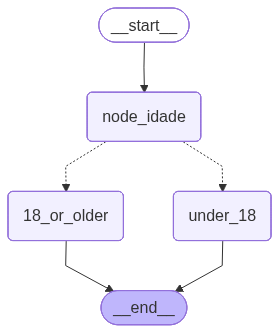

In [10]:
display(
    Image(graph.get_graph().draw_mermaid_png())
)

In [11]:
logger.info("---Executing the graph---")
initial_state = {
    "nome": "Fabio Lima",
    "ano_nascimento": 1975,
    "idade": None,
    "next_node" : None,
}
result = graph.invoke(initial_state)

# O output do logger do LangSmith aparecerá aqui
logger.info(f"Estado final: {result}")
logger.success("Graph executed successfully")

2025-09-18 21:08:14.503 | INFO     | __main__:<module>:1 - ---Executing the graph---
2025-09-18 21:08:14.687 | INFO     | __main__:node_idade:9 - ---> Executing the NODE: node_idade ---
2025-09-18 21:08:14.688 | INFO     | __main__:router:10 - ---Routing the user to the appropriate node---
2025-09-18 21:08:14.689 | INFO     | __main__:node_18_or_older:11 - ---Executing node_18_or_older---
You are older, so you can drink 🍺
2025-09-18 21:08:14.690 | INFO     | __main__:<module>:11 - Estado final: {'nome': 'Fabio Lima', 'idade': 50, 'ano_nascimento': 1975, 'next_node': None}
2025-09-18 21:08:14.691 | SUCCESS  | __main__:<module>:12 - Graph executed successfully
